# Notebook Nombres Premiers

> **Groupe D**
>
> Alexandre De Cuyper
>
> Hendrix Montalvan

1. [Introduction](#Introduction)
2. [Données](#Données)
3. [Modèle](#Modèle)
4. [Visualisation](#Visualisation)
5. [Résultats](#Résultats)

# Introduction

---

On cherche a faire un réseau qui prédit si un nombre est un nombre premier. 

On va utiliser l'apprentissage supervisé avec une classification binaire (nombres premiers et les multiples). On va diviser les données en 2 groupes: entrainement et test. Pour les algorithmes on va essayer les méthodes Linear SVM, RBF SVM, Random Forest, etc; et voir quelle est la méthode qui prédit mieux les nombres premiers dehors des données d'apprentissage.

---

Dans ce Notebook nous allons voir si un réseau de neurones est capable de prédire si un nombre est premier ou non en lui montrant un jeu de données de plusieurs millions de nombres premiers.

Nous allons pour cela tester 2 types de datasets différents, un contenant les multiples des nombres et un autre sans, afin de voir comment cette information va impacter l'apprentissage du réseau et par conséquent ses prédicitons.

## Importations néscessaires

In [1]:
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import keras
import keras.models as km
import keras.layers as kl

TensorFlow 1.x selected.


Using TensorFlow backend.


# Données

In [2]:
#@title Options pour les datasets
#@markdown Choisissez les datasets à importer

use_primes = True #@param {type:"boolean"}
suffix = "" if use_primes else "_mini"
use_primes_with_multiples = True #@param {type:"boolean"}
suffix = "" if use_primes_with_multiples else "_mini"

In [3]:
#@title Télécharger les données

#@markdown Ceci va télécharger l'archive depuis Github et la décompresser dans le répertoire `data`

import sys
import os
import tarfile
from urllib.request import urlretrieve

URL = "https://github.com/Undreak/MML_Nombres_Premiers/raw/master"
FILES = [
    "prime_with_multiples.tar.gz",
    "primes.tar.gz"
]


def download_data(output_dir, use_primes=False, use_primes_with_multiples=False):
  if use_primes_with_multiples:
    files = [FILES[0], '']
    urls = [f"{URL}/{files}", '']
  if use_primes:
    files = [FILES[1], '']
    urls = [f"{URL}/{files}", '']
  if use_primes and use_primes_with_multiples:
    files = FILES
    urls = [
          f"{URL}/{filename}"
          for filename in files
    ]
  
  if not os.path.exists(output_dir):
    print(f"Création du répertoire {output_dir}")
    os.mkdir(output_dir)

  for url, filename in zip(urls, files):
    if url == '':
      continue
    output_file = os.path.join(output_dir, filename)
    if os.path.exists(output_file):
      print(f"{filename} déjà téléchargé.")
      continue

    print(f"Téléchargement à partir de {url}...")
    urlretrieve(url, output_file)
    print(f"==> Fichier enregistré sous {output_file}")

    if filename.endswith("tar.gz"):
      print("Extraction de l'archive...")
      with tarfile.open(output_file, "r:gz") as f:
        f.extractall(output_dir)
      print("Terminé.\n")

download_data("data", use_primes, use_primes_with_multiples)

prime_with_multiples.tar.gz déjà téléchargé.
primes.tar.gz déjà téléchargé.


## Charger les données

Les données compressé téléchargé depuis Github sont déjà préparé au format `.csv` et peuvent être lu par pandas ou numpy.

Chargement des données du dataset sans les multiples

In [4]:
primes = pd.read_csv('data/primes.csv', skiprows=1, delimiter=',').astype(int)

Chargement des données du dataset avec les multiples

In [5]:
primes_with_multiples = pd.read_csv("data/prime_with_multiples.csv")

Pour obtenir les multiples des nombres du dataset nous avons utilisé ces fonctions.

In [6]:
def numbers_to_digits(number,max_digit,base): #Cette fonction convertit les nombres en chiffres en la base de votre choix
    tab=np.zeros(max_digit)
    i=0
    for i in range(max_digit):
        tab[i]=number%base
        number=number//base
    return tab

def add_random_multiples(tab,max_digit,base): #Cette fonction ajoute des nombres multiples au dataset
    dim = 2*len(tab)-1
    output_tab = np.zeros((dim,max_digit+1))
    output_tab[0][0] = 0
    output_tab[0,1:] = numbers_to_digits(1,max_digit,base)
    i = 0
    prev_value = 1
    p = 1
    while p < dim:
        diff = tab[i]-prev_value
        if diff == 1:
            output_tab[p][0] = 1
            output_tab[p,1:] = numbers_to_digits(tab[i],max_digit,base)
            prev_value = tab[i]
            p = p+1
            i = i+1
        elif diff == 2:
            output_tab[p][0] = 0
            output_tab[p,1:] = numbers_to_digits(tab[i]-1,max_digit,base)
            p = p+1
            output_tab[p][0] = 1
            output_tab[p,1:] = numbers_to_digits(tab[i],max_digit,base)
            prev_value = tab[i]
            p = p+1
            i = i+1
            if i == len(tab):
                p = dim
            else:
                pass
        elif diff>2:
            random = np.random.randint(1,diff)
            output_tab[p][0] = 0
            output_tab[p,1:] = numbers_to_digits(tab[i-1]+random,max_digit,base)
            p = p+1
            output_tab[p][0] = 1
            output_tab[p,1:] = numbers_to_digits(tab[i],max_digit,base)
            prev_value = tab[i]
            p = p+1
            i = i+1
            if i == len(tab):
                p = dim
            else:
                pass
        else:
            pass
    return output_tab

def conv_pnum(nombre):
  num = ''
  for i in range(9):
    newnum = primes_with_multiples[f"{9 - i}"][nombre]
    num = np.char.add(num,newnum.astype(int).astype(str))
  return num.astype(int)

def conv_pnums(fn, ln):
  indice = np.zeros(ln)
  j = 0
  for i in primes_with_multiples[fn:fn+ln].index:
    indice[j] = conv_pnum(i)
    j += 1
  return indice

Si on veux travailler avec un dataset en base décimale:

In [41]:
primes['1'][:N]

0             2
1             3
2             4
3             5
4             6
          ...  
99995     99997
99996     99998
99997     99999
99998    100000
99999    100001
Name: 1, Length: 100000, dtype: int64

In [42]:
primes_with_multiples = add_random_multiples(primes['1'][:N+n],9,10)
df = pd.DataFrame({
  'prime': prime_with_multiples[:,0],
  '1': prime_with_multiples[:,1],
  '2': prime_with_multiples[:,2],
  '3': prime_with_multiples[:,3],
  '4': prime_with_multiples[:,4],
  '5': prime_with_multiples[:,5],
  '6': prime_with_multiples[:,6],
  '7': prime_with_multiples[:,7],
  '8': prime_with_multiples[:,8],
  '9': prime_with_multiples[:,9]})
df.to_csv('prime_with_multiples.csv', index=False)

KeyError: ignored

Si on veux travailler avec un dataset binaire:

In [ ]:
primes_with_multiples=add_random_multiples(primes,28,2)
df_binaire = pd.DataFrame({
  'prime': prime_with_multiples[:,0],
  '1': prime_with_multiples[:,1],
  '2': prime_with_multiples[:,2],
  '3': prime_with_multiples[:,3],
  '4': prime_with_multiples[:,4],
  '5': prime_with_multiples[:,5],
  '6': prime_with_multiples[:,6],
  '7': prime_with_multiples[:,7],
  '8': prime_with_multiples[:,8],
  '9': prime_with_multiples[:,9],
  '10': prime_with_multiples[:,10],
  '11': prime_with_multiples[:,11],
  '12': prime_with_multiples[:,12],
  '13': prime_with_multiples[:,13],
  '14': prime_with_multiples[:,14],
  '15': prime_with_multiples[:,15],
  '16': prime_with_multiples[:,16],
  '17': prime_with_multiples[:,17],
  '18': prime_with_multiples[:,18],
  '19': prime_with_multiples[:,19],
  '20': prime_with_multiples[:,20],
  '21': prime_with_multiples[:,21],
  '22': prime_with_multiples[:,22],
  '23': prime_with_multiples[:,23],
  '24': prime_with_multiples[:,24],
  '25': prime_with_multiples[:,25],
  '26': prime_with_multiples[:,26],
  '27': prime_with_multiples[:,27],
  '28': prime_with_multiples[:,28]})
df_binaire.to_csv('prime_with_multiples_binaire.csv', index=False)

TypeError: ignored

## Préparation des datasets

Nombres premiers sans multiples

In [ ]:
N = 100000

X_train = np.arange(2,N+2)
Y_train = np.isin(X_train, primes['2'][:N])*1

X_test = np.arange(N+3, 2*N+3)
Y_test = np.isin(X_test, primes['2'][N+3:2*N+3])*1

Nombres premiers avec multiples

In [7]:
N = 100000

Y_train = primes_with_multiples['prime'][:N]
X_train = np.zeros((N,9))
for i in range(9):
  X_train[:,i] = primes_with_multiples[f"{i+1}"][:N]

Y_test = primes_with_multiples['prime'][N+1:2*N+1]
X_test = np.zeros((N,9))
for i in range(9):
  X_test[:,i] = primes_with_multiples[f"{i+1}"][N+1:2*N+1]

# Modèle

On construit un réseau de neurones convolutif

In [8]:
f_activation = 'relu'
l_activation = 'sigmoid'
dropout_rate = 0.05

model = tf.keras.Sequential([
  tf.keras.layers.Dense(16, activation=f_activation, input_dim=9),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(32, activation=f_activation),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(32, activation=f_activation),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(64, activation=f_activation),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(128, activation=f_activation),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(1, activation=l_activation)
])

model.compile(optimizer='Adam', loss='binary_crossentropy')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dr

In [9]:
history = model.fit(X_train, Y_train,
  batch_size=32,
  epochs=15,
  validation_split=0.3,
  verbose=1)

Train on 70000 samples, validate on 30000 samples
Epoch 1/15
70000/70000 [==============================] - 7s 98us/sample - loss: 0.6606 - val_loss: 0.5815
Epoch 2/15
70000/70000 [==============================] - 6s 87us/sample - loss: 0.5008 - val_loss: 0.6028
Epoch 3/15
70000/70000 [==============================] - 6s 85us/sample - loss: 0.4325 - val_loss: 0.8783
Epoch 4/15
70000/70000 [==============================] - 6s 85us/sample - loss: 0.3930 - val_loss: 0.6965
Epoch 5/15
70000/70000 [==============================] - 6s 87us/sample - loss: 0.3768 - val_loss: 1.0011
Epoch 6/15
70000/70000 [==============================] - 6s 85us/sample - loss: 0.3711 - val_loss: 1.0264
Epoch 7/15
70000/70000 [==============================] - 6s 86us/sample - loss: 0.3630 - val_loss: 1.0978
Epoch 8/15
70000/70000 [==============================] - 6s 87us/sample - loss: 0.3605 - val_loss: 0.7796
Epoch 9/15
70000/70000 [==============================] - 6s 86us/sample - loss: 0.3578 - val_

# Visualisations

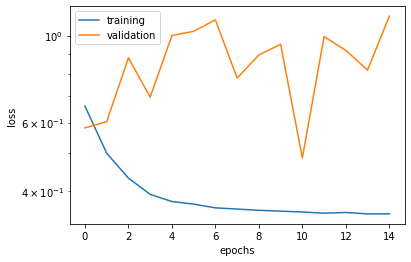

100000/100000 [==============================] - 3s 29us/sample - loss: 1.7024
1.7024276100826263


In [10]:
plt.figure()                    
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()

ev = model.evaluate(X_test, Y_test)
print(ev)

`var_loss` evolution bizarre, augmente au lieu de diminuer

***

Prédictions pour le dataset avec les multiples

Visualisation des résultats

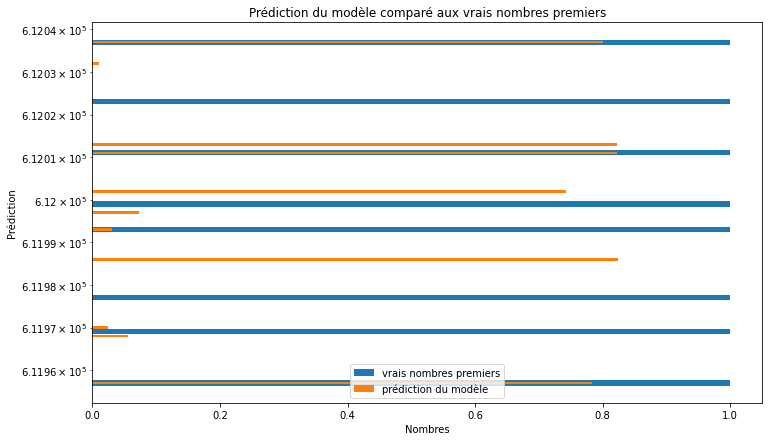

In [12]:
N = 100000
n = 15

pred = model.predict(X_test[:n])
ind = conv_pnums(N,n)
numpreal = np.isin(ind, primes['2'])*1

fig = plt.subplots(1, 1, figsize=(12, 7))

plt.barh(ind, numpreal, height=1.2, label='vrais nombres premiers')
plt.barh(ind, pred.T[0], height=0.6, label='prédiction du modèle')

plt.yscale('log')
plt.xlabel('Nombres')
plt.ylabel('Prédiction')
plt.title('Prédiction du modèle comparé aux vrais nombres premiers')
plt.legend(loc='lower center')

plt.show()

## Representations experimentale

Representation polaire de la repartitions des nombres premiers

(explication: https://math.stackexchange.com/questions/885879/meaning-of-rays-in-polar-plot-of-prime-numbers#885894)

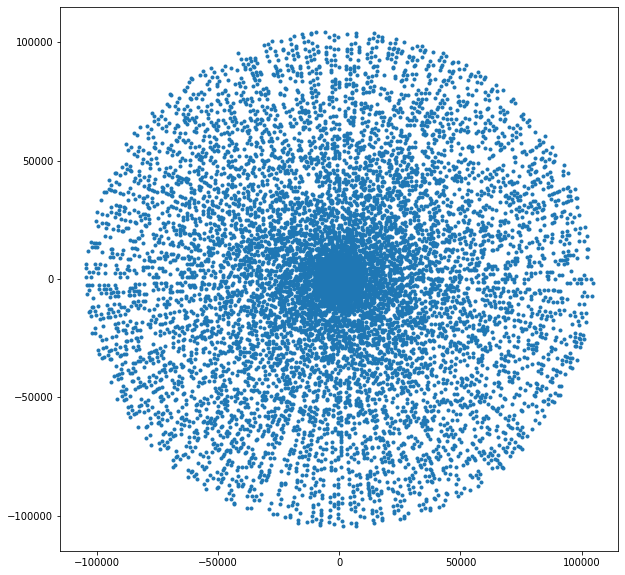

In [256]:
n = 10000
fig = plt.subplots(1, 1, figsize=(10, 10))
plt.scatter(primes[:n]*np.cos(primes[:n]), primes[:n]*np.sin(primes[:n]), marker='.')
plt.show()

Superposition des predictions avec la representation circulaire (en cours)

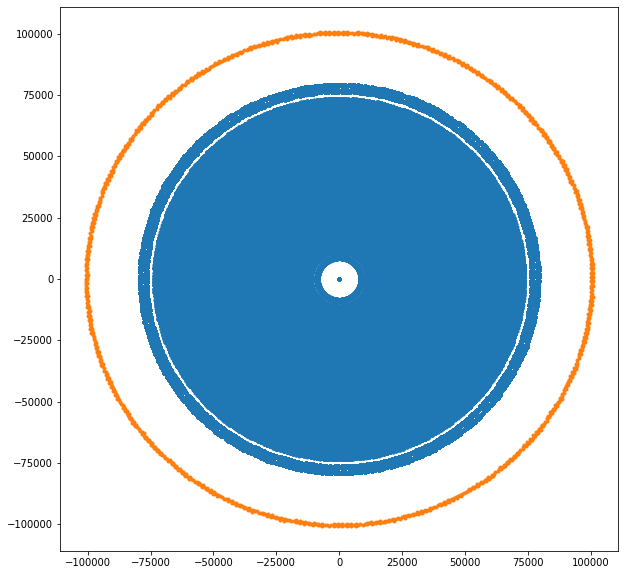

In [15]:
n_pred = 1000
pred = model.predict(X_test[:n_pred])
num = primes_with_multiples.index[N+1:N+n_pred+1]
xs = np.array(num*np.cos(num))*pred
ys = np.array(num*np.sin(num))*pred

numreal = primes[N+1:N+n_pred+1]['1']
xr = np.array(numreal*np.cos(numreal))
yr = np.array(numreal*np.sin(numreal))

fig = plt.subplots(1, 1, figsize=(10, 10))
plt.scatter(xs, ys, marker='.')
plt.scatter(xr, yr, marker='.')
plt.show()

In [13]:
pred = model.predict(X_test)
X_pred = (pred > 0.5)*1
X_pred = X_pred.reshape(100000,)

In [33]:
test = conv_pnums(N+1,N)

In [1]:
X_pred*test.reshape(N,1)

NameError: ignored

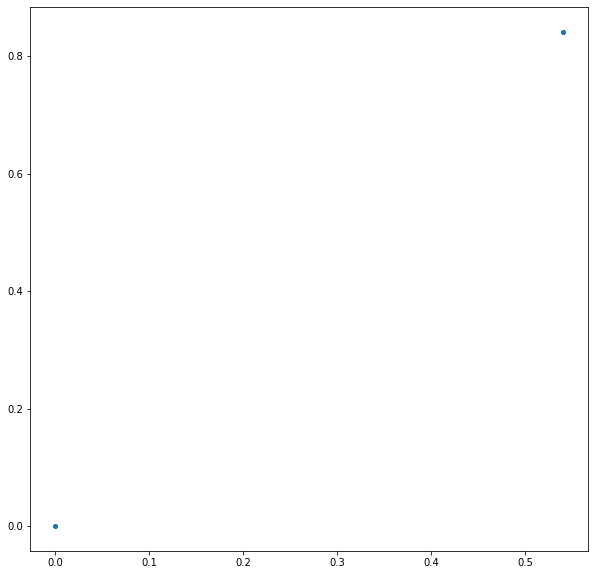

In [18]:
n = 10000
fig = plt.subplots(1, 1, figsize=(10, 10))
plt.scatter(X_pred[:n]*np.cos(X_pred[:n]), X_pred[:n]*np.sin(X_pred[:n]), marker='.')
plt.show()

# Résultats

Comme on peut le voir sur les graphiques ci-dessus, le modèle sans les multiples est incapable de faire une quelquonce prédiction, tous les nombres ont la même probabilité d'être premier. 

Tandis que pour le dataset avec les multiples nous obtenons déjà des résultats plus interessant. 
On peut voir que certains point correspondent et qu'ils ont donc bien été prédit.

Toutefois il reste encore des erreurs et pour cela il faut pouvoirs essayer d'autres méthodes, on va donc essayer avec un dataset en binaire pour voir quel impact cela va avoir sur les prédictions du modèle. 